# Importing libraries and processing the data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from power.ml_ops.cross_val import get_folds, train_test_split, get_X_y_seq
from power.ml_ops.model import init_baseline_keras, compile_model, initialize_model, train_model

# tensforflow
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Lambda

2024-03-13 15:52:44.001827: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 15:52:44.542174: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 15:52:44.550279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 15:52:47.761596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('../raw_data/1980-2022_pv.csv')

In [3]:
df.head(2)

,_0-1,_0,local_time,electricity,irradiance_direct,irradiance_diffuse,temperature,source
0,NaN,315532800000,1980-01-01 01:00:00+01:00,0.0,0.0,0.0,-1.296,data/pv_data/1980_pv.csv
1,NaN,315536400000,1980-01-01 02:00:00+01:00,0.0,0.0,0.0,-1.216,data/pv_data/1980_pv.csv


In [4]:
df = df.drop(columns=['irradiance_direct', 'source', '_0-1', 'temperature', 'irradiance_diffuse'])
df.electricity = df.electricity.astype(float)
df.local_time = df.local_time.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))
df['_0'] = pd.to_datetime(df['_0'], unit='ms').dt.tz_localize('UTC')
df.rename(columns={'_0': 'utc_time'}, inplace=True)
df.utc_time = pd.to_datetime(df.utc_time,utc=True)

In [29]:
pv_df = df.copy()

In [31]:
min_date = '1980-01-01 00:00:00'
max_date = '2019-12-31 23:00:00'
train = pv_df[pv_df['utc_time'] <= max_date]
test = pv_df[pv_df['utc_time'] > max_date]

In [32]:
train = train[['electricity']]
test = test[['electricity']]

# Cross validation

In [33]:
TARGET = 'electricity'
fold_length = 43800             # 5 years
fold_stride = 43800             # 5 years
train_test_ratio = 0.8          # 5 yrs/6 yrs
input_length = 48               # number of obsevations per one sequence
output_length = 24              # Day-ahead predictions
n_seq_train = 500               # number_of_sequences_train
n_seq_val = 100                 # number_of_sequences_test
n_unit = 48                     # number of hidden units
learning_rate = 0.02
patience = 5
epochs = 50
batch_size = 32

In [34]:
def cross_validate_baseline_and_lstm():

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(train, fold_length, fold_stride)

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_val) = train_test_split(fold, train_test_ratio, input_length)

        X_train, y_train = get_X_y_seq(fold_train, n_seq_train, input_length, output_length, gap_hours=12)
        X_val, y_val = get_X_y_seq(fold_val, n_seq_val, input_length, output_length, gap_hours=12)

        # 2 - Modelling
        # =========================================

        ##### Baseline Model
        baseline_model = init_baseline_keras()
        mae_baseline = baseline_model.evaluate(X_val, y_val, verbose=0)[1]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = initialize_model(X_train, y_train, n_unit=n_unit)
        model = compile_model(model, learning_rate=learning_rate)
        model, history = train_model(model,
                                     X_train,
                                     y_train,
                                     validation_split = 0.2,
                                     batch_size = batch_size,
                                     epochs = epochs)

        # Create a figure and axes object with 1 row and 2 columns
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

        # Plot training & validation MAE values
        axes[0].plot(history.history['mae'])
        axes[0].plot(history.history['val_mae'])
        axes[0].set_title('Model MAE')
        axes[0].set_ylabel('MAE')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        axes[1].plot(history.history['loss'])
        axes[1].plot(history.history['val_loss'])
        axes[1].set_title('Model Loss')
        axes[1].set_ylabel('Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Validation'], loc='upper left')

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()

        res = model.evaluate(X_val, y_val, verbose=0)    # evaluating LSTM (metric)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        print(f"improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model


--------------------------------------------------
MAE baseline fold n°0 = 0.23


2024-03-12 14:32:49.735943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 14:32:49.744561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 14:32:49.748693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

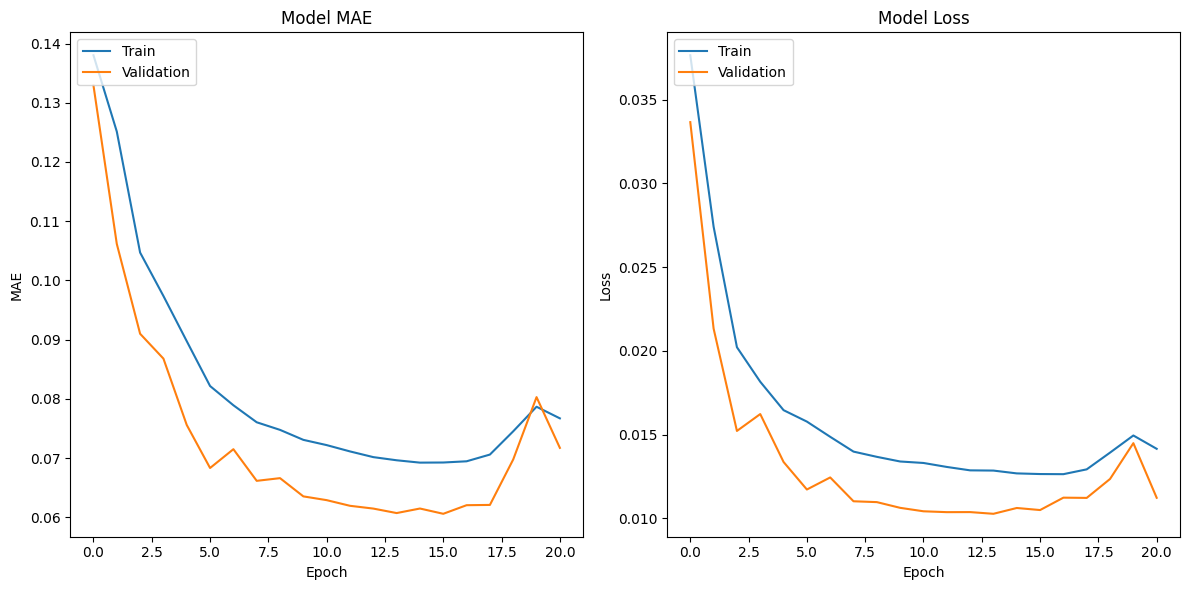

MAE LSTM fold n°0 = 0.07
improvement over baseline: 68.69 % 

--------------------------------------------------
MAE baseline fold n°1 = 0.26


2024-03-12 14:33:11.382745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 14:33:11.386620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 14:33:11.389402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

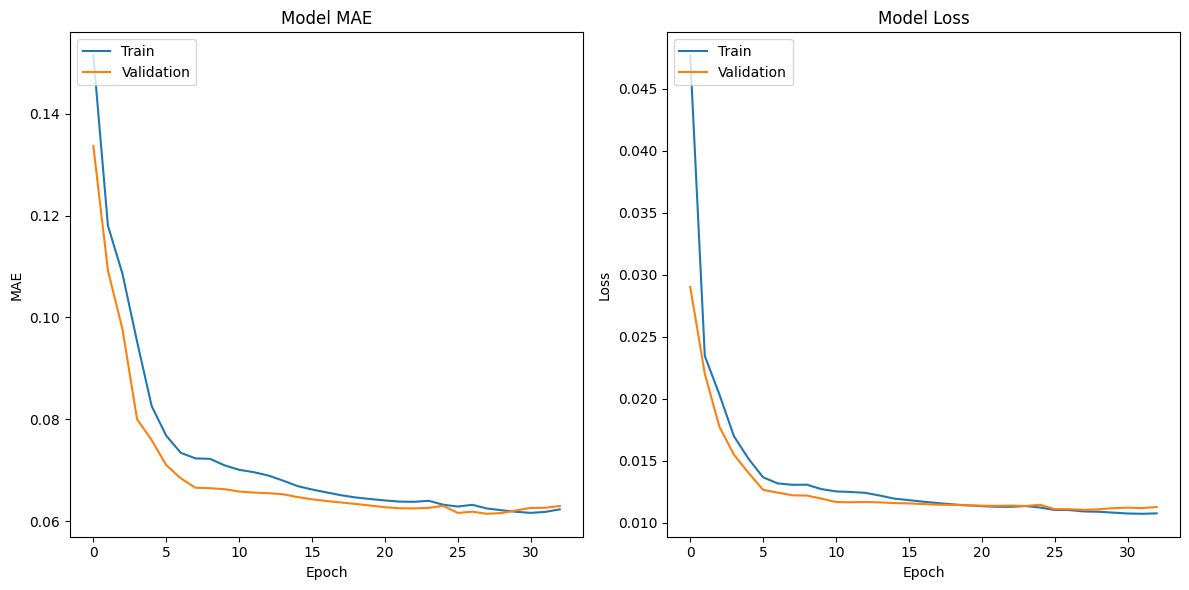

MAE LSTM fold n°1 = 0.06
improvement over baseline: 74.82 % 

--------------------------------------------------
MAE baseline fold n°2 = 0.28


2024-03-12 14:33:25.855619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 14:33:25.858088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 14:33:25.859660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

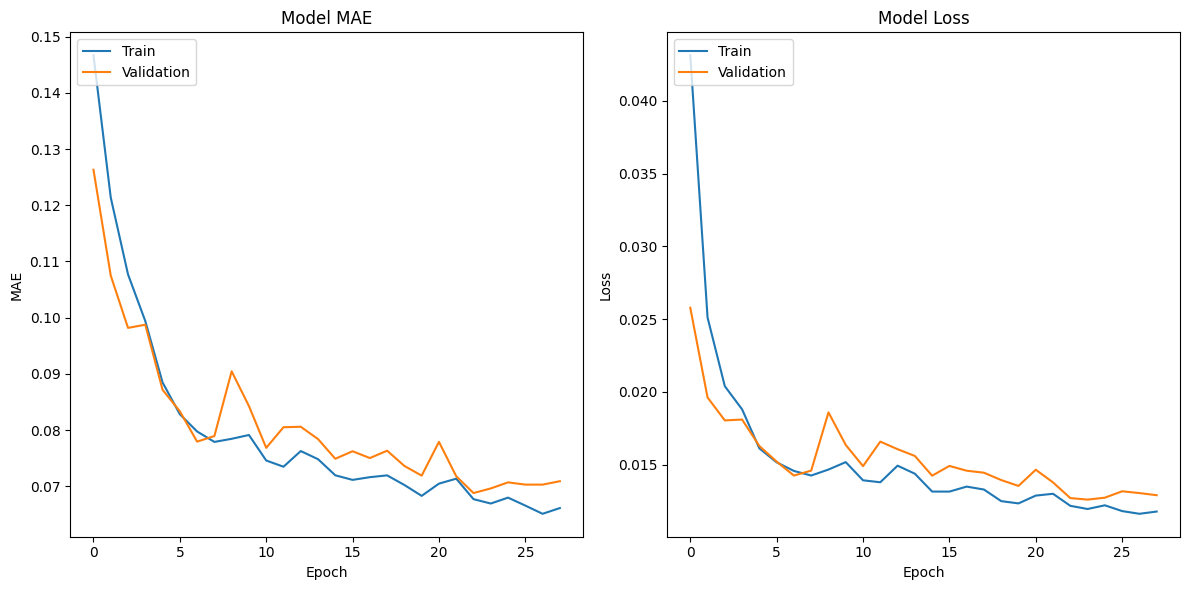

MAE LSTM fold n°2 = 0.07
improvement over baseline: 75.2 % 

--------------------------------------------------
MAE baseline fold n°3 = 0.27


2024-03-12 14:33:38.594080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 14:33:38.596485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 14:33:38.599334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

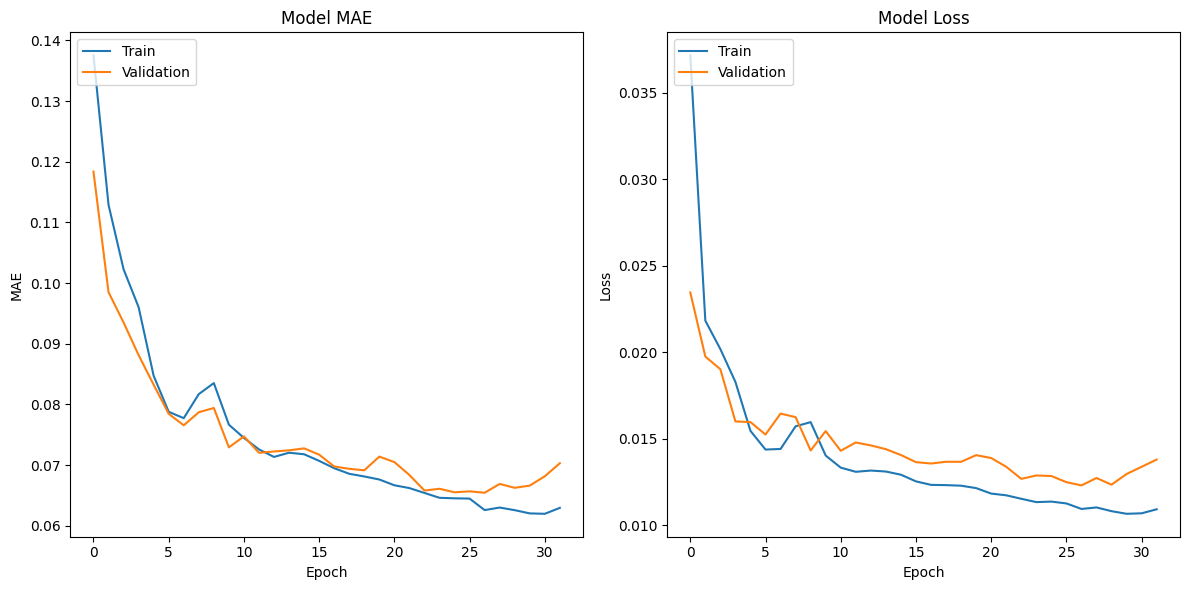

MAE LSTM fold n°3 = 0.06
improvement over baseline: 76.7 % 

--------------------------------------------------
MAE baseline fold n°4 = 0.25


2024-03-12 14:33:53.681469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 14:33:53.683531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 14:33:53.685252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

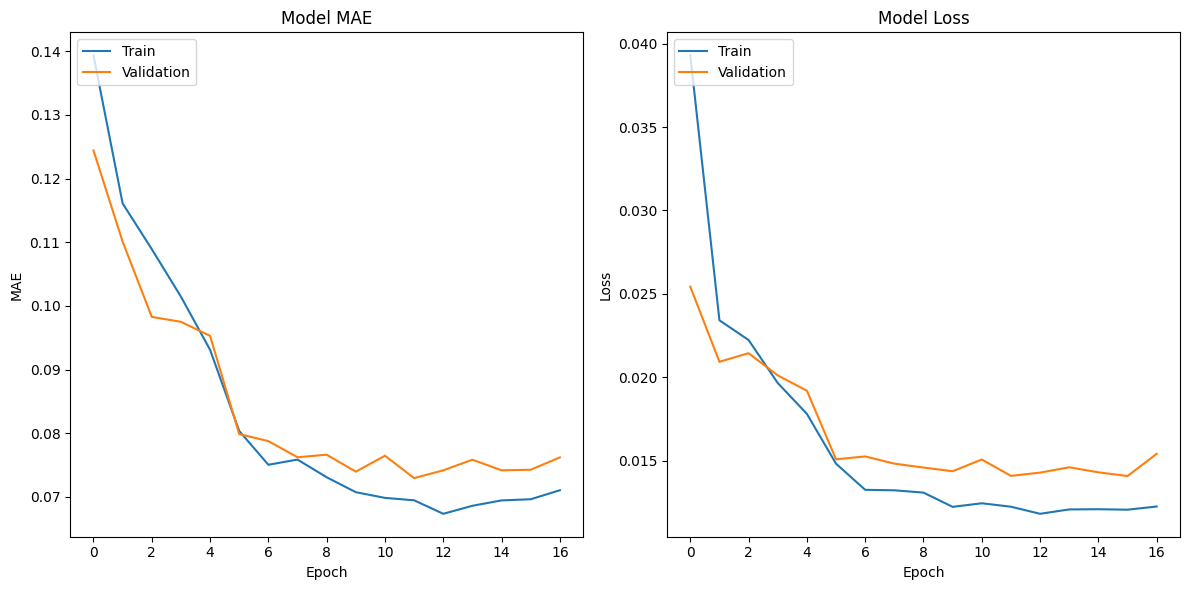

MAE LSTM fold n°4 = 0.07
improvement over baseline: 70.13 % 

--------------------------------------------------
MAE baseline fold n°5 = 0.26


2024-03-12 14:34:03.540026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 14:34:03.543081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 14:34:03.545739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

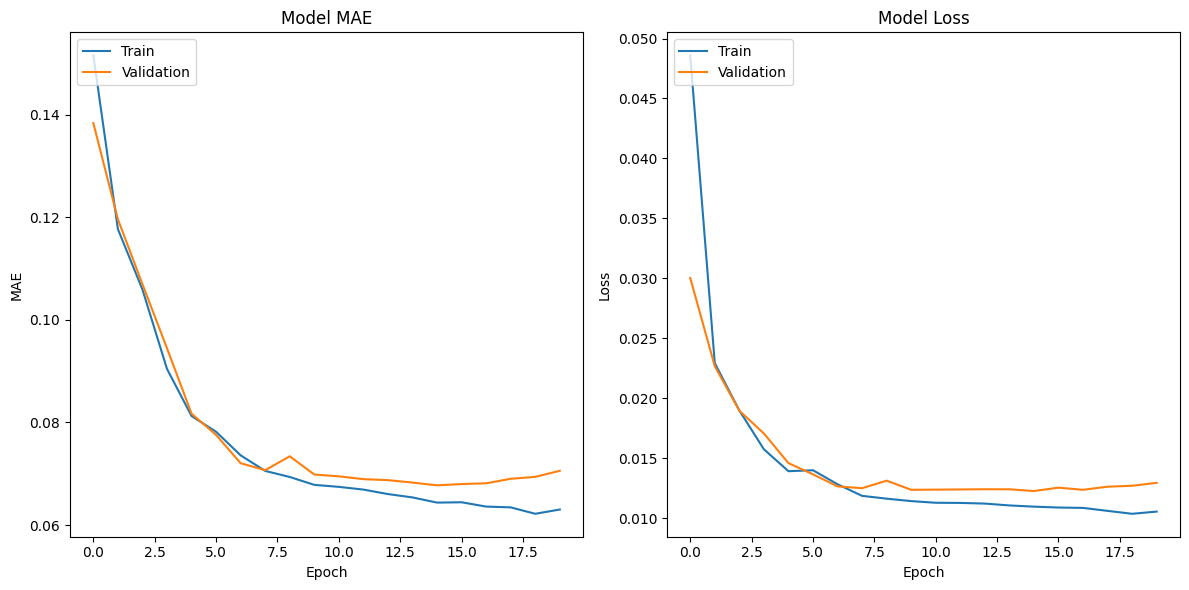

MAE LSTM fold n°5 = 0.06
improvement over baseline: 76.11 % 

--------------------------------------------------
MAE baseline fold n°6 = 0.26


2024-03-12 14:34:14.234905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 14:34:14.237035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 14:34:14.238840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

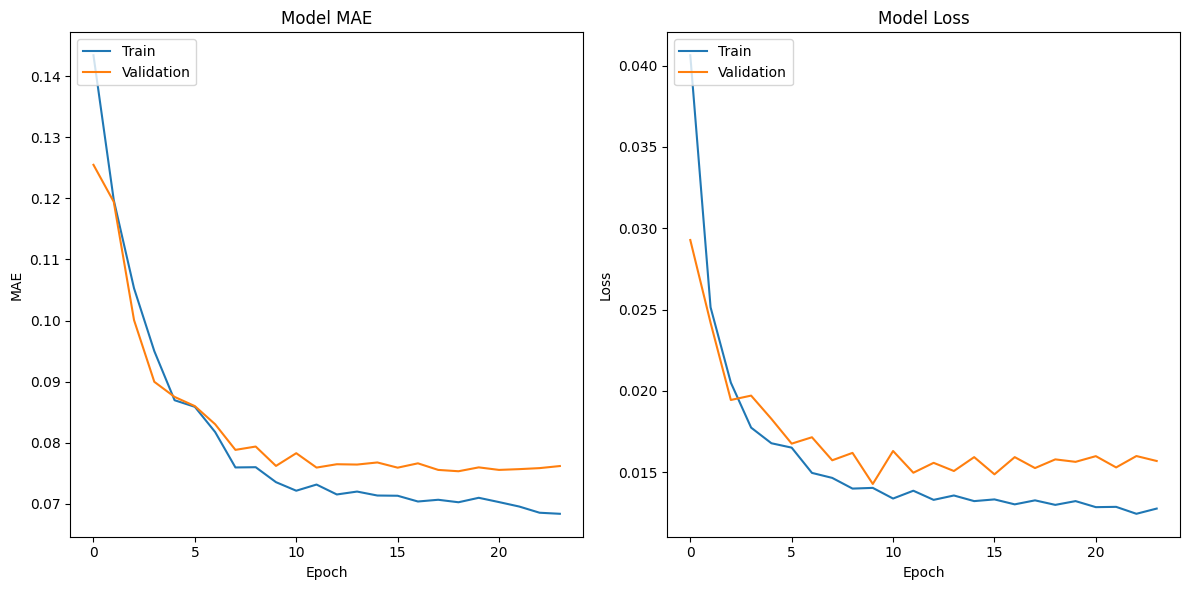

MAE LSTM fold n°6 = 0.06
improvement over baseline: 75.0 % 

--------------------------------------------------
MAE baseline fold n°7 = 0.29


2024-03-12 14:34:26.797396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 14:34:26.800436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 14:34:26.801979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

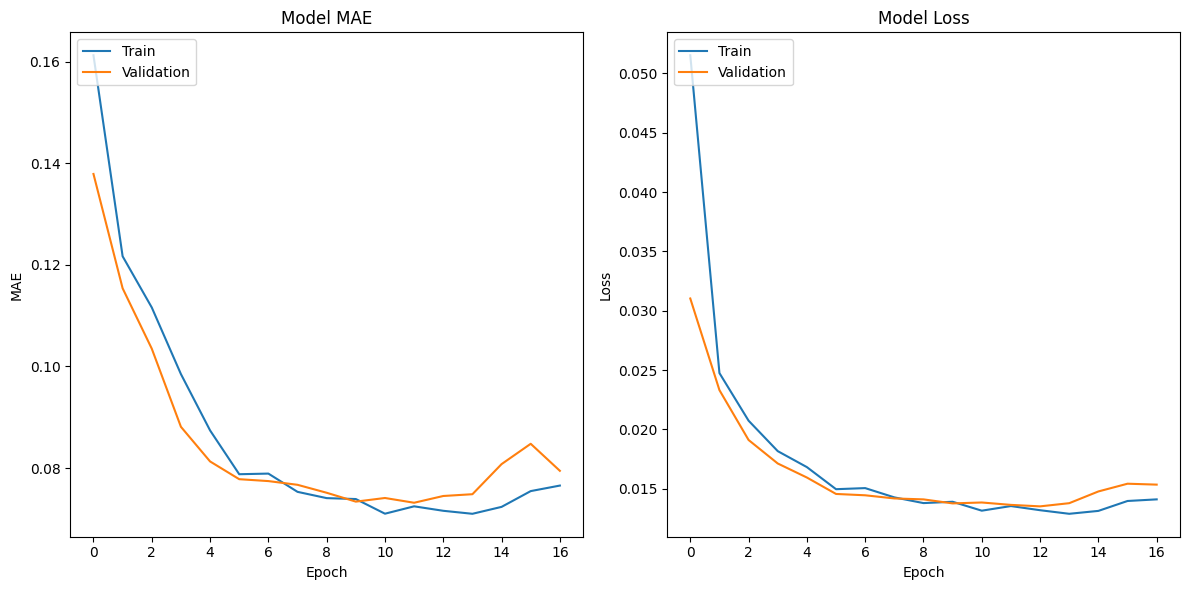

MAE LSTM fold n°7 = 0.07
improvement over baseline: 74.91 % 



In [35]:
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

In [36]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")

average percentage improvement over baseline = 74.0%


# Prediction

In [47]:
X_train, y_train = get_X_y_seq(train, number_of_sequences=10000, input_length=48, output_length=24, gap_hours=12)

In [48]:
model = initialize_model(X_train, y_train, n_unit=n_unit)
model = compile_model(model, learning_rate=learning_rate)
model, history = train_model(model,
                                X_train,
                                y_train,
                                validation_split = 0.1,
                                batch_size = batch_size,
                                epochs = epochs)

2024-03-12 14:48:26.213185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 14:48:26.216007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 14:48:26.217895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [59]:
from power.params import *
from power.ml_ops.data import get_data_with_cache
from pathlib import Path
import tensorflow as tf

input_pred = '2021-05-08 12:00:00'

query = f"""
    SELECT *
    FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
    ORDER BY utc_time
"""

data_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
data_processed = get_data_with_cache(
    gcp_project=GCP_PROJECT,
    query=query,
    cache_path=data_processed_cache_path,
    data_has_header=True
)

X_pred = data_processed[data_processed['utc_time'] < input_pred][-48:]


Load data from local CSV...
✅ Data loaded, with shape (376944, 3)


In [60]:
X_pred = X_pred[['electricity']]

In [61]:
X_pred = X_pred.to_numpy()
X_pred_tf = tf.convert_to_tensor(X_pred)
X_pred_tf = tf.expand_dims(X_pred_tf, axis=0)

In [62]:
y_pred = model.predict(X_pred_tf)

1/1 [==============================] - 0s 102ms/step


In [57]:
y_pred[0]

array([-0.0144421 , -0.02268313, -0.03012741, -0.02750001,  0.01143871,
        0.08208539,  0.18152219,  0.312756  ,  0.44816756,  0.5182704 ,
        0.55890894,  0.5551112 ,  0.5021799 ,  0.42772403,  0.33165652,
        0.22386   ,  0.13041162,  0.05917854,  0.01755672,  0.00913155,
        0.00843337,  0.01096576,  0.00374363, -0.0097196 ], dtype=float32)

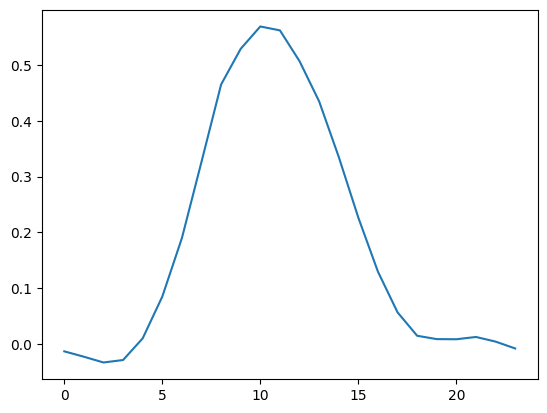

In [63]:
plt.plot(y_pred[0])